In [1]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def sample_clf_data(n_samples=1000, n_features=20, n_test=1000, sep=2):
    
    mean_neg = np.zeros(n_features)
    mean_pos = sep  * np.ones(n_features) / np.sqrt(n_features)
    
    beta_true = mean_pos - mean_neg
    
    def sample_xy(n):
        n_pos = int(n / 2)
        n_neg = n - n_pos
        
        X_pos = np.random.multivariate_normal(mean=mean_pos, cov=np.eye(n_features), size=n_pos)
        X_neg = np.random.multivariate_normal(mean=mean_neg, cov=np.eye(n_features), size=n_neg)
        
        X = np.vstack([X_pos, X_neg])
        y = np.concatenate([np.ones(n_pos), -1 * np.ones(n_neg)])
    
        return X, y
    
    X_train, y_train = sample_xy(n_samples)
    X_test, y_test = sample_xy(n_test)
    
    return X_train, y_train, X_test, y_test, beta_true 

In [8]:
def solve_svm(X, y, lambd, solver_kws={}):
    
    n_samples, n_features = X.shape
    y = y.reshape(-1, 1)
    
    beta = cp.Variable((n_features, 1))
    offset = cp.Variable()
    lambd = cp.Parameter(value=lambd, nonneg=True)
    
    # TODO: should we make this + offset
    loss = cp.sum(cp.pos(1 - cp.multiply(y, X * beta + offset)))
    reg = cp.norm(beta, 1)
    objective = loss / n_samples + lambd * reg

    problem = cp.Problem(cp.Minimize(objective))
    problem.solve(**solver_kws)
    
    return beta.value, offset.value, problem



In [9]:
def lin_clf_predict(x, beta, offset):
    return np.sign(x.dot(beta) + offset).reshape(-1)

In [10]:
def tuning_curve(X_train, y_train, X_test, y_test, lambd_values, algo, solver_kws={}):

    n_test = X_test.shape[0]
    n_tune_values = len(lambd_values)
    
    train_error = np.zeros(n_tune_vals)
    test_error = np.zeros(n_tune_vals)

    for i, lambd in enumerate(lambd_values):
        beta, offset, problem = algo(X_train, y_train, lambd, solver_kws)

        tr_pred = lin_clf_predict(X_train, beta, offset)
        test_pred = lin_clf_predict(X_test, beta, offset)

        train_error[i] = np.mean(tr_pred != y_train)
        test_error[i] = np.mean(test_pred != y_test)

    plt.plot(lambd_values, train_error, label="Train error")
    plt.plot(lambd_values, test_error, label="Test error")
    plt.xscale('log')
    plt.legend(loc='upper left')
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.ylim(0, 1)
    
    return train_error, test_error

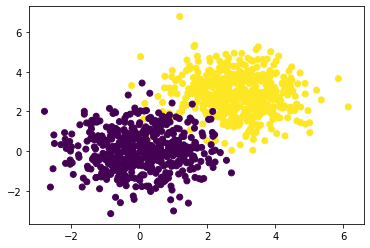

In [11]:
np.random.seed(1)
X_train, y_train, X_test, y_test, beta_true = sample_clf_data(n_samples=1000, n_features=2, n_test=1000, sep=4)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# solve_svm(X_train, y_train, lambd=.1, solver_kws={'max_iter': 10000})

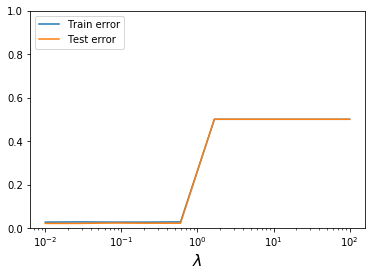

In [12]:
n_tune_vals = 10
lambd_values = np.logspace(-2, 2, n_tune_vals)

train_error, test_error = tuning_curve(X_train, y_train, X_test, y_test,
                                       lambd_values, algo=solve_svm, solver_kws={'solver': cp.ECOS,
                                                                                 # 'max_iter': int(1e6),
                                                                                 'verbose': False})

# DWD

In [50]:
def solve_DWD_first_formulation(X, y, c=1.0):
    # 2.6 from https://arxiv.org/pdf/1508.05913.pdf
    
    n_samples, n_features = X.shape
    y = y.reshape(-1)
    
    X = cp.Parameter(shape=X.shape, value=X)
    y = cp.Parameter(shape=y.shape, value=y)
    c = cp.Parameter(value=c, nonneg=True)
    
    print(y.shape)
    
    beta = cp.Variable(shape=n_features)
    offset = cp.Variable()
    eta = cp.Variable(shape=n_samples, nonneg=True)
    
    d = cp.multiply(y, offset + X * beta)  + eta
    
    objective = sum(1.0 / d[i] for i in range(n_samples)) + \
        c * sum(1.0 / eta[i] for i in range(n_samples))
    
    constraints = [0 <= d,
                   beta * beta == 1]
    
    problem = cp.Problem(cp.Minimize(objective),
                         constraints=constraints)
    
    problem.solve()
    
    return beta.value, offset.value, problem



In [51]:
def solve_DWD(X, y, c=1.0, solver_kws={}):
    # 2.7 from https://arxiv.org/pdf/1508.05913.pdf
    
    n_samples, n_features = X.shape
    y = y.reshape(-1)
    
    # problem data
    X = cp.Parameter(shape=X.shape, value=X)
    y = cp.Parameter(shape=y.shape, value=y)
    c = cp.Parameter(value=c, nonneg=True)
    
    # optimization variables
    beta = cp.Variable(shape=n_features)
    offset = cp.Variable()
    eta = cp.Variable(shape=n_samples, nonneg=True)
    
    rho = cp.Variable(shape=n_samples)
    sigma = cp.Variable(shape=n_samples)
    
    # objective funtion
    objective = np.ones(n_samples).T @ (rho + sigma + c * eta)
    
    # setup constraints
    Y_tilde = cp.diag(y)
    constraints = [rho - sigma == Y_tilde @ X @ beta + offset * y + eta,
                   cp.SOC(cp.Parameter(value=1), beta)]

    constraints.extend([cp.SOC(rho[i], cp.vstack([sigma[i], 1]))
                        for i in range(n_samples)])
    
    # solve problem
    problem = cp.Problem(cp.Minimize(objective),
                         constraints=constraints)
    
    problem.solve(**solver_kws)
    
    return beta.value, offset.value, problem

In [42]:
beta, offset, problem = solve_DWD(X_train, y_train, c=.1)#, solver_kws={'max_iter': 10000})

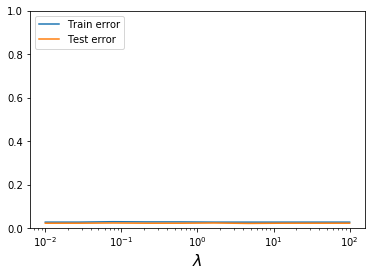

In [52]:
n_tune_vals = 10
lambd_values = np.logspace(-2, 2, n_tune_vals)

train_error, test_error = tuning_curve(X_train, y_train, X_test, y_test,
                                       lambd_values, algo=solve_DWD)